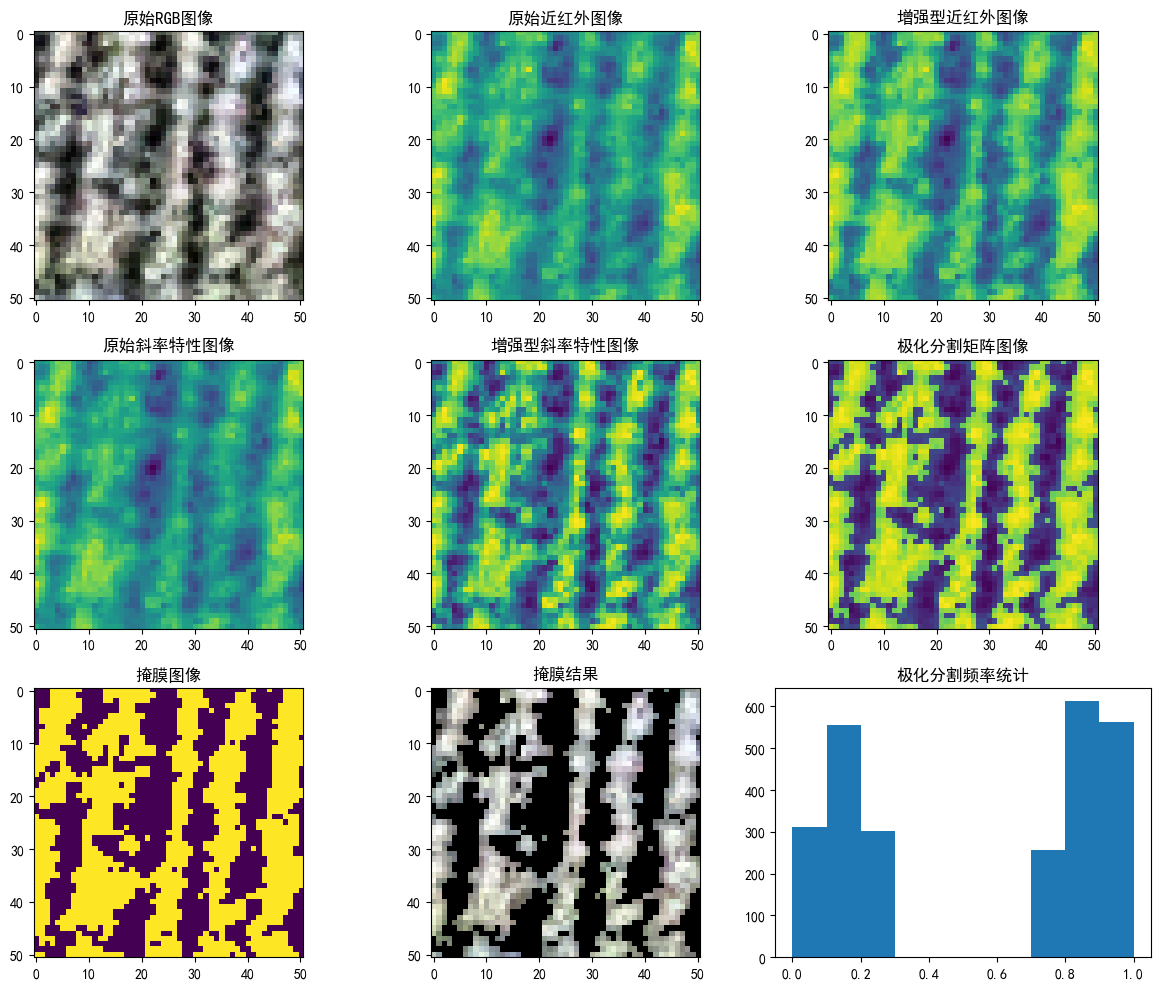

In [1]:
# 通过第一步分割获得掩膜（mask）
%run ./1_generate_mask.ipynb

In [2]:
# 用掩膜 Ab_q 对多波段影像 A 进行逐像素乘积，屏蔽非目标区域（如土壤、阴影）
# np.newaxis 用于扩展 Ab_q 维度，保证广播正确
masked_A = A * Ab_q[:, :, np.newaxis]

# 提取不同波段的掩膜图像（波段索引从0开始）
masked_Ar = masked_A[:, :, 50]   # 红光波段（第51波段）
masked_Ag = masked_A[:, :, 25]   # 绿光波段（第26波段）
masked_Ab = masked_A[:, :, 3]    # 蓝光波段（第4波段）
masked_Anir = masked_A[:, :, 100] # 近红外波段（第101波段）
masked_Ae = masked_A[:, :, 60]    # 红边波段（第61波段）

# 计算各个波段掩膜区域的平均反射率
Rmean = masked_Ar.mean()
Gmean = masked_Ag.mean()
Bmean = masked_Ab.mean()

# 计算各个波段掩膜区域的反射率标准差（波动程度）
Rstd = masked_Ar.std()
Gstd = masked_Ag.std()
Bstd = masked_Ab.std()

# 计算近红外和红边波段的平均反射率
NIR = masked_Anir.mean()
RE = masked_Ae.mean()

In [3]:
# 计算常用植被指数，反映植被生长状况和生理特征：

# NDVI：归一化植被指数，常用植被健康指标
NDVI = (NIR - Rmean) / (NIR + Rmean + 1e-8)

# EVI2：改进型植被指数，增强对土壤背景的抑制效果
EVI2 = 2.5 * (NIR - Rmean) / (1 + NIR + 2.4 * Rmean)

# RVI：简单植被比率指数
RVI = NIR / (Rmean + 1e-8)

# DVI：差值植被指数
DVI = NIR - Rmean

# RDVI：归一化差值植被指数，减少NDVI对土壤影响
RDVI = (NIR - Rmean) / ((NIR + Rmean + 1e-8) ** 0.5)

# MSR：修正植被指数，结合比率和差异特征
MSR = (NIR / (Rmean + 1e-8) - 1) / ((NIR / (Rmean + 1e-8) + 1) ** 0.5)

# MCARI：修正土壤调节植被指数，突出叶绿素特征
MCARI = (NIR - RE - 0.2 * (NIR - Gmean)) / (NIR / (RE + 1e-8))

# OSAVI：优化土壤调节植被指数，减少土壤影响
OSAVI = (1.16 * (NIR - Rmean)) / (NIR + Rmean + 0.16)

# WDRVI：加权差异植被指数，增强对绿植的响应
WDRVI = (0.1 * NIR - Rmean) / (0.1 * NIR + Rmean + 1e-8)

In [4]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import minmax_scale

# 直接使用单通道近红外图像
gray_Anir = masked_Anir  # 已经是二维灰度图

# 归一化到0~1之间（如果原始不是归一化的）
gray_Anir_norm = minmax_scale(gray_Anir.ravel()).reshape(gray_Anir.shape)

# 转成 uint8, 取值范围0-63（glcm的levels=64）
gray_uint8 = (gray_Anir_norm * 63).astype(np.uint8)

# 计算灰度共生矩阵 GLCM，多角度
glcm = graycomatrix(gray_uint8,
                    distances=[1],
                    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                    levels=64,
                    symmetric=True,
                    normed=True)

# 计算纹理特征，四个角度的特征相加
contrast = graycoprops(glcm, 'contrast').sum()
correlation = graycoprops(glcm, 'correlation').sum()
energy = graycoprops(glcm, 'energy').sum()
homogeneity = graycoprops(glcm, 'homogeneity').sum()

In [5]:
# 自定义能量与同质性计算
energy_custom = np.sum(glcm**2)

# 生成二维坐标索引 i,j 形状(64,64)
i, j = np.indices((64, 64))

# 扩展维度 (64,64) -> (64,64,1,1)，方便广播
i_exp = i[:, :, np.newaxis, np.newaxis]
j_exp = j[:, :, np.newaxis, np.newaxis]

# 计算分母矩阵，形状自动广播到 glcm (64,64,1,4)
denominator = 1.0 + (i_exp - j_exp) ** 2

# 计算同质性
homogeneity_custom = np.sum(glcm / denominator)

In [6]:
# 掩膜比率
Mask = masked_Anir == 0
Mask_rate = np.sum(Mask) / (m * n)
Green_rate = 1 - Mask_rate

In [7]:
# 最终输出（23种特征）
outmat = [NDVI, EVI2, RVI, DVI, RDVI, MSR, MCARI, OSAVI, WDRVI, NIR,
          contrast, correlation, energy, homogeneity,
          1e-5 * energy_custom, 1e-4 * homogeneity_custom,
          Rmean, Gmean, Bmean, Rstd, Gstd, Bstd, Green_rate]

outmat, np.array(outmat).shape

([0.448079018874398,
  0.21182693820739126,
  2.6237067982506455,
  0.11483543,
  0.22683771389973287,
  0.8529647499123554,
  0.035259298855010536,
  0.3199958241914528,
  -0.5843205886902486,
  0.18555966,
  1971.3744627450965,
  2.432684327433329,
  1.38637830103231,
  1.9233705252471407,
  4.818831324259901e-06,
  0.00019233705252471382,
  0.07072423,
  0.06663694,
  0.03841238,
  0.064369924,
  0.060633335,
  0.03512139,
  0.550557477893118],
 (23,))